## Create predictions middle slices

In [17]:
#from segment_anything import SamPredictor, sam_model_registry
from models.sam import SamPredictor, sam_model_registry
from models.sam.utils.transforms import ResizeLongestSide
from skimage.measure import label
from models.sam_LoRa import LoRA_Sam
#Scientific computing 
import numpy as np
import os
#Pytorch packages
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets
#Visulization
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
#Others
from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import copy
from utils.dataset import Public_dataset
import torch.nn.functional as F
from torch.nn.functional import one_hot
from pathlib import Path
from tqdm import tqdm
from utils.losses import DiceLoss
from utils.dsc import dice_coeff
import cv2
import monai
from utils.utils import vis_image,inverse_normalize,torch_percentile
from argparse import Namespace
import cfg
import PIL
import torchio as tio
import json
from pathlib import Path
import csv
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

arch="vit_b"  # Change this value as needed
finetune_type="vanilla"
#dataset_name="MRI-Prostate"  # Assuming you set this if it's dynamic
dataset_name="ACDC_blank"  # Assuming you set this if it's dynamic

# Construct the checkpoint directory argument
checkpoint_dir= f"2D-SAM_{arch}_decoder_{finetune_type}_{dataset_name}_noprompt"

args_path = f"{checkpoint_dir}/args.json"

# Reading the args from the json file
with open(args_path, 'r') as f:
    args_dict = json.load(f)


# Converting dictionary to Namespace
args = Namespace(**args_dict)

sam_fine_tune = sam_model_registry[args.arch](args,checkpoint=os.path.join(args.dir_checkpoint,'checkpoint_best.pth'),num_classes=args.num_cls)
sam_fine_tune = sam_fine_tune.to('cuda').eval()

## evaluate a image volume and save predictions

In [18]:
# Function to evaluate a single image slice
def evaluate_1_slice(image_path, model):
    """
    Evaluates a single image slice using the provided model.

    Parameters:
    - image_path: Path to the image slice file.
    - model: The model used for evaluation.

    Returns:
    - ori_img: The original image after normalization.
    - pred: The prediction from the model.
    - Pil_img: The PIL image of the original slice.
    """
    # Load the image
    img = Image.open(image_path).convert('RGB')
    Pil_img = img.copy()
    
    # Resize the image to 1024x1024
    img = transforms.Resize((1024, 1024))(img)
    
    # Transform the image to a tensor and normalize
    transform_img = transforms.Compose([
        transforms.ToTensor(),
    ])
    img = transform_img(img)
    imgs = torch.unsqueeze(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), 0).cuda()
    
    # Perform model inference without gradient calculation
    with torch.no_grad():
        # Get image embeddings from the image encoder
        img_emb = model.image_encoder(imgs)
        
        # Get sparse and dense embeddings from the prompt encoder
        sparse_emb, dense_emb = model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )
        
        # Get the prediction from the mask decoder
        pred, _ = model.mask_decoder(
            image_embeddings=img_emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
        )
        
        # Get the most likely prediction
        pred = pred.argmax(dim=1)
    
    # Get the original image after normalization
    ori_img = inverse_normalize(imgs.cpu()[0])
    
    return ori_img, pred, Pil_img

# save predicted middle slices

In [25]:
# Define paths
image_dir = './datasets/ACDC_blank/test/images/'
output_dir = './sam_output_middle/'

# Create the output directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Get all image files from the image directory
image_files = sorted(os.listdir(image_dir))

# Group files by patient and frame
grouped_files = {}
for img_file in image_files:
    # Extract patient and frame identifier (e.g., "patient101_frame01")
    base_name = "_".join(img_file.split('_')[:2])
    grouped_files.setdefault(base_name, []).append(img_file)

# Iterate over each patient-frame group
for base_name, slices in grouped_files.items():
    # Sort slices and find the middle slice
    #slices = sorted(slices)                                                            # this does not work because slice 10 comes after slice 2
    slices = sorted(slices, key=lambda x: int(x.split('_')[-1].split('.')[0]))          # this ensures that slice 10 comes after slice 2
    
    middle_index = len(slices) // 2  # Floor division to find middle
    #print(middle_index)
    middle_slice = slices[middle_index]

    # Full path for the middle slice
    image_path = os.path.join(image_dir, middle_slice)
    # print(image_path)
    # Evaluate the middle slice
    ori_img, pred_1, Pil_img1 = evaluate_1_slice(image_path, sam_fine_tune)

    # Convert the predicted mask to a NumPy array
    mask_pred_1 = ((pred_1).cpu()).float().numpy()
    pil_mask1 = Image.fromarray(np.array(mask_pred_1[0], dtype=np.uint8), 'L').resize(Pil_img1.size, resample=Image.NEAREST)

    # Resize the mask to match the size of the original image
    #original_image = Image.open(image_path)  # Load the original image
    #original_size = original_image.size  # (width, height)

    # Resize the mask and remove singleton dimensions
   # resized_mask = Image.fromarray(mask_pred_1.squeeze()).resize(original_size, resample=Image.NEAREST)
    #resized_mask = np.array(resized_mask)  # Convert back to a NumPy array

    # Ensure the mask has two dimensions (height, width)
    #if resized_mask.ndim == 3:
    #    resized_mask = resized_mask[:, :, 0]  # Remove any extra channel dimension

    # Create the patient_frame-specific folder
    patient_frame_folder = os.path.join(output_dir, base_name)
    Path(patient_frame_folder).mkdir(parents=True, exist_ok=True)

    # Save the resized predicted mask as a NumPy file
    #slice_number = middle_slice.split('_')[-1].split('.')[0]  # Extract slice number (e.g., "5" from "patient101_frame01_4.png")
    output_mask_path = os.path.join(patient_frame_folder, f"{middle_index}.npy")
    np.save(output_mask_path, pil_mask1)

print("Predicted masks resized and saved successfully.")


Predicted masks resized and saved successfully.


# Check examples plot both and difference

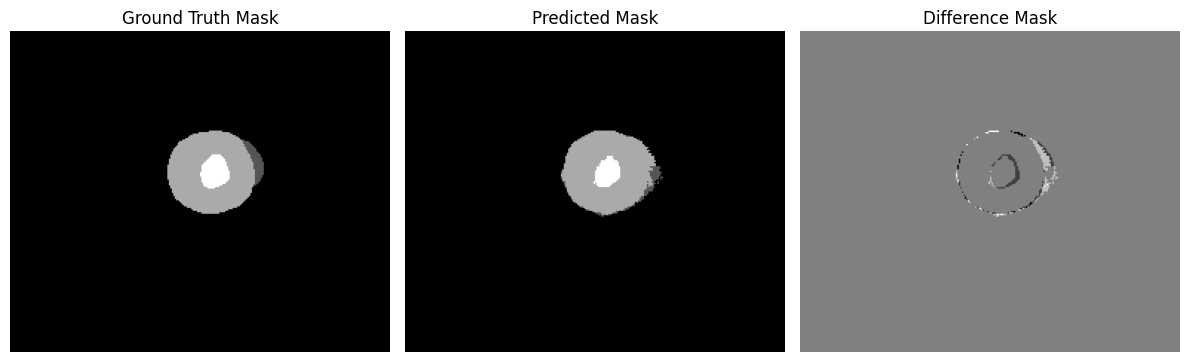

In [27]:
# File paths
saved_image_path = "./sam_output_middle/patient114_frame11/5.npy"
truth_image_path = "C:/Users/Windows/Desktop/Tijana/Medical-SAM2-main/Medical-SAM2-main/data/Test/mask/patient_frame11_patient114/5.npy"

# Load the .npy files
saved = np.load(saved_image_path)
truth = np.load(truth_image_path)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Display the ground truth mask
axes[0].imshow(truth, cmap='gray')
axes[0].set_title("Ground Truth Mask")
axes[0].axis('off')

# Display the predicted mask
axes[1].imshow(saved, cmap='gray')
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

# Display the difference 
axes[2].imshow(saved-truth, cmap='gray')
axes[2].set_title("Difference Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()
